### Parameter generator:

Author: Betsy Landells

This notebook allows you to generate best fit parameters for the drift model. Using simulated data for 9 different scenarios (3 cell types X 3 pressures), best fit parameters are generated for t(r), and this is inverted and use to give r(t). Commissioning data requires taking time stamps t ($t_{calo} - t_{anode}$) and converting them to a radius with a given uncertainty $\sigma_r$

In [306]:
# IMPORTS

import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.odr import ODR, Model, Data, RealData
from scipy import optimize
from scipy import linalg
import uncertainties as unc  
import uncertainties.unumpy as unumpy
from uncertainties import unumpy
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm
import pandas as pd
from iminuit import Minuit
from scipy.stats import chi2
import csv


### Importing data

Regions are divided as follows:
- **CT** for centre cell, single quarter
- **TLL**, top left cell, top left quarter, representing the cell corner case 
- **TLR**, top left cell, top right quarter, representing any edge cell.

In [307]:
def unpack(cell_region):
        xs = []
        ys = []
        ts = []
        errts = []
        for drift_times in cell_region.dtimes:
            xs.append(drift_times.xs)
            ys.append(drift_times.ys)
            ts.append(drift_times.dtime)
            errts.append(drift_times.errdtime)
        return xs, ys, ts, errts

In [308]:
class Cell:
    def __init__(self, region):
        unpacked_region = unpack(region)
        self.x = np.array(unpacked_region[0])
        self.y = np.array(unpacked_region[1])
        self.t = np.array(unpacked_region[2])
        self.errt = np.array(unpacked_region[3])
        self.r = np.sqrt(np.array(unpacked_region[0])**2 + np.array(unpacked_region[1])**2)
        

In [309]:
CTL850 = Cell(ROOT.TFile.Open("summaryCTL850.root"))
CTL880 = Cell(ROOT.TFile.Open("summaryCTL880.root"))
CTL910 = Cell(ROOT.TFile.Open("summaryCTL910.root"))
TLL850 = Cell(ROOT.TFile.Open("summaryTLL850.root"))
TLL880 = Cell(ROOT.TFile.Open("summaryTLL880.root"))
TLL910 = Cell(ROOT.TFile.Open("summaryTLL910.root"))
TLR850 = Cell(ROOT.TFile.Open("summaryTLR850.root"))
TLR880 = Cell(ROOT.TFile.Open("summaryTLR880.root"))
TLR910 = Cell(ROOT.TFile.Open("summaryTLR910.root"))

In [310]:
regions = [CTL850, CTL880, CTL910, TLL850, TLL880, TLL910, TLR850, TLR880, TLR910]
cell_names = ["CTL850", "CTL880", "CTL910", "TLL850", "TLL880", "TLL910", "TLR850", "TLR880", "TLR910"]
max_cell_len = np.sqrt(2.2**2+2.2**2)

#### Fitting distance to time

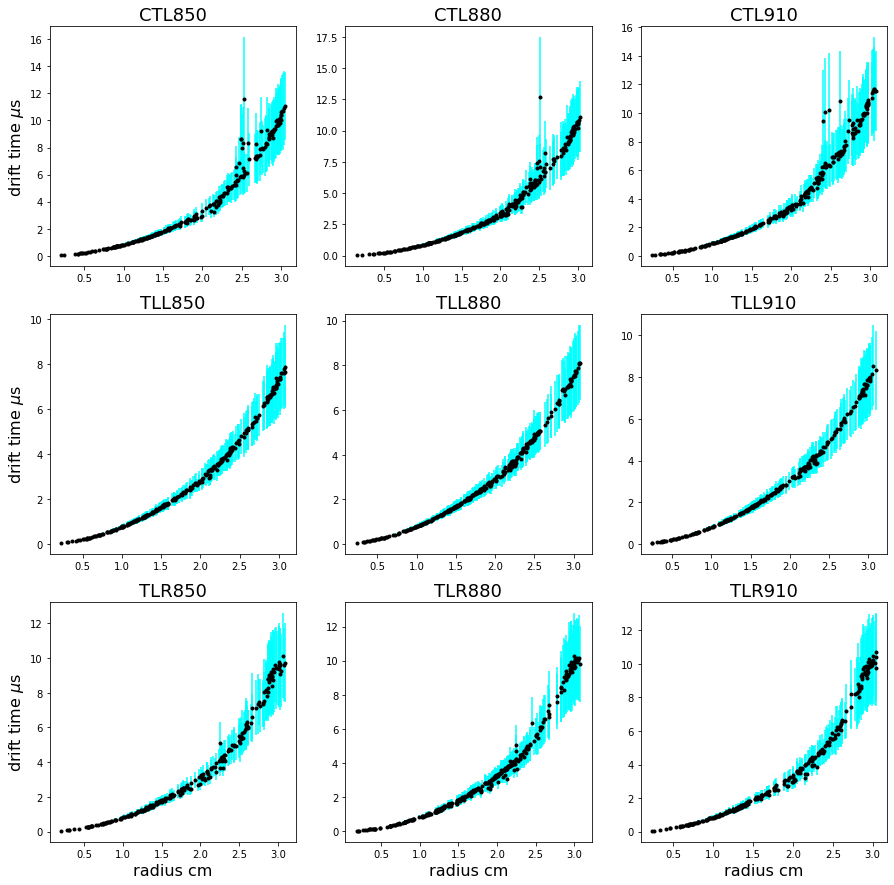

In [311]:
#plot 9 images of the 9 regions
figs, axs = plt.subplots(3,3, figsize=(15,15))
count = 0
for i in range(3):
    for j in range(3):
        label = cell_names[count]
        axs[i,j].errorbar(regions[count].r,np.array(regions[count].t)/1e-6,yerr=np.array(regions[count].errt)/1e-6,fmt='.',ecolor = 'cyan',color='black')
        axs[i,j].set_title(label,fontsize=18)
        axs[i,0].set_ylabel(r'drift time $\mu$s',fontsize=16)
        axs[2,j].set_xlabel('radius cm',fontsize=16)

        count += 1

Drift time equation as a function of radial distance:
$$t(r) = \frac{a \times r}{r^b}$$

In [312]:
def trialfunc(r,a,b):
    """ A function that calculates time from distance"""
    denom = r**b
    return a*r / denom

Initial parameter values:

$0<r<2.2$, a = $1\times 10^{-6}$, b = $-0.9$

$2.2<r<3.5$, a = $1\times 10^{-6}$, b = $-2$


In [313]:
a_guess = 1e-6
b_guess = -0.9 #for 0 to x=2.2
b_guess2 = -2.0 #for x>2.2

In [314]:
def perform_fit(region,cutoff):
    
    """THIS FUNCTION FITS SIMULATED DATA: T AS A FUNCTION OF R 
    
    PROVIDES CURVE FIT PARAMETERS FOR LOWER AND UPPER REGIONS r < cutoff and r >= cutoff"""
    
    r_low = np.array(region.r)[region.r<cutoff]
    r_up = np.array(region.r)[region.r>=cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]

    #a, b for r<cut off
    popt,pcov = curve_fit(trialfunc,r_low,time_low,p0=[a_guess,b_guess],sigma=err_low)
    perr = np.sqrt(np.diag(pcov))
    
    #a2, b2 for r>cut off
    popt2,pcov2 = curve_fit(trialfunc,r_up,time_up,p0=[a_guess,b_guess],sigma=err_up)
    perr2 = np.sqrt(np.diag(pcov2))

    return popt,perr,popt2,perr2

**Inverse function:** Radial distance as a function of drift time:
$$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$$

In [315]:
def invertfunc(t,a,b):
    
    """ The inverse function which calculates radius as a function of time"""
    power = (1/(1-b))
    
    return (t/a)**power

**Error propagation:** 
$$\begin{equation}
\sigma_r^2 = \sigma_a^2(\frac{\partial r}{\partial a})^2 + \sigma_b^2(\frac{\partial r}{\partial b})^2 + \sigma_t^2(\frac{\partial r}{\partial t})^2
\end{equation}$$


In [316]:
def error_propagation(ts,errts,a,erra,b,errb):
    
    """ Generates r and delta r based on uncertainty in t, a, b"""
    
    t_tuple = unumpy.uarray(ts, errts)
    a_tuple = unumpy.uarray(a, erra)
    b_tuple = unumpy.uarray(b, errb)
    r = (t_tuple/a_tuple)**(1/(1-b_tuple))
    err = unumpy.std_devs(r)
    val = unumpy.nominal_values(r)
    return err, val

Reduced chi-squared as a measure of goodness-of-fit:

In [317]:
def chi2_reduce(region,lo_cutoff):
    
    #get params from curve fit
    popt,perr,popt2,perr2 = perform_fit(region,lo_cutoff)
    
    
    """Reduced Chi squared (Chi squared per degree of freedom) for r<cut off"""
   
    r_low = np.array(region.r)[region.r<lo_cutoff]
    time_low = np.array(region.t)[region.r<lo_cutoff]
    err_low = np.array(region.errt)[region.r<lo_cutoff]
    
    #get predicted radii and errors from inverse function
    errs,vals = error_propagation(time_low,err_low,popt[0],perr[0],popt[1],perr[1])

    chi2_low = sum(((vals-r_low)**2)/errs)
    
    """Reduced Chi squared (Chi squared per degree of freedom) for r >= cut off"""

    r_hi = np.array(region.r)[region.r>=lo_cutoff]
    time_hi = np.array(region.t)[region.r>=lo_cutoff]
    err_hi = np.array(region.errt)[region.r>=lo_cutoff]
        
    #get predicted radii and errors from inverse function
    errs,vals = error_propagation(time_hi,err_hi,popt2[0],perr2[0],popt2[1],perr2[1])
    chi2_hi = sum(((vals-r_hi)**2)/errs)

    return chi2_low/len(r_low), chi2_hi/len(r_hi)

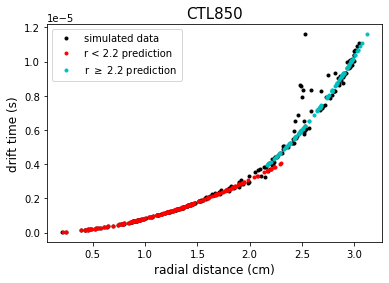

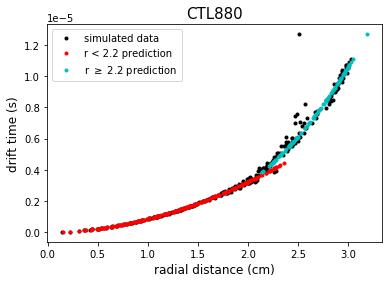

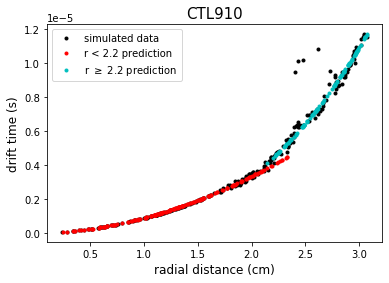

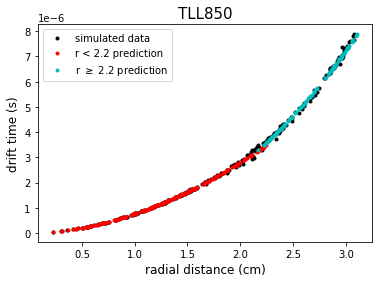

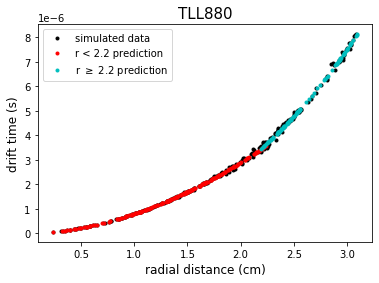

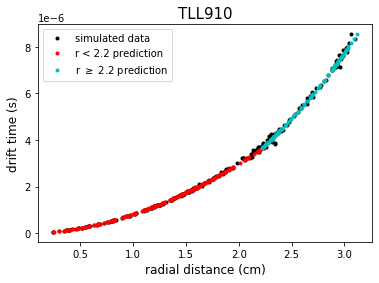

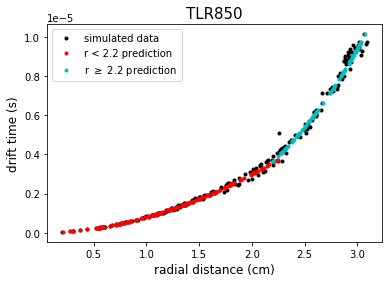

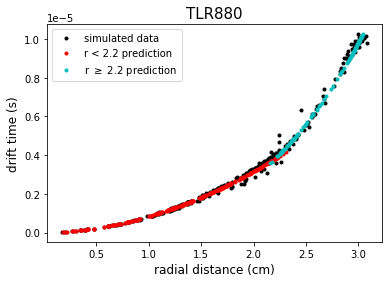

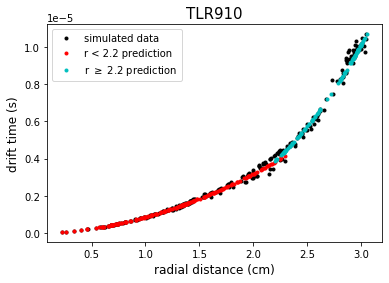

In [318]:
f = open('drift_parameters.csv','w')
f.write('{} {} {} {} {} {} {} {}\n'.format('a', 'erra', 'b', 'errb', 'a2', 'erra2', 'b2', 'errb2'))
cutoff=2.2
count = 0

for region in regions:
    popt,perr,popt2,perr2 = perform_fit(region,cutoff)
    chi_lo,chi_hi = chi2_reduce(region,cutoff)
    plt.plot(region.r,region.t,'k.',label='simulated data')
    plt.plot(invertfunc(np.array(region.t)[np.array(region.r)<cutoff],popt[0],popt[1]),np.array(region.t)[np.array(region.r)<cutoff],'r.',label='r < 2.2 prediction')
    plt.plot(invertfunc(np.array(region.t)[np.array(region.r)>=cutoff],popt2[0],popt2[1]),np.array(region.t)[np.array(region.r)>=cutoff],'c.',label=r'r $\geq$ 2.2 prediction')
    plt.legend()
    plt.title(cell_names[count],fontsize=15)
    plt.xlabel('radial distance (cm)',fontsize=12)
    plt.ylabel('drift time (s)',fontsize=12)
    plt.show()
    count+=1
    f.write('{} {} {} {} {} {} {} {}\n'.format(popt[0],perr[0],popt[1],perr[1],popt2[0],perr2[0],popt2[1],perr2[1]))

#### Error propagation

In [319]:
def fit_err_low(region,cutoff):
    
    r_low = np.array(region.r)[region.r<cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]

    popt1,pcov1 = curve_fit(trialfunc,r_low,time_low+err_low,p0=[a_guess,b_guess])
    popt2,pcov2 = curve_fit(trialfunc,r_low,time_low,p0=[a_guess,b_guess],sigma=err_low)
    popt3,pcov3 = curve_fit(trialfunc,r_low,time_low-err_low,p0=[a_guess,b_guess])

    perr1 = np.sqrt(np.diag(pcov1))
    perr2 = np.sqrt(np.diag(pcov2))
    perr3 = np.sqrt(np.diag(pcov3))


    return popt1,perr1,popt2,perr2,popt3,perr3

In [320]:
def fit_err_high(region,cutoff):
    
    r_up = np.array(region.r)[region.r>=cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]
    
    popt1,pcov1 = curve_fit(trialfunc,r_up,time_up+err_up,p0=[a_guess,b_guess])
    popt2,pcov2 = curve_fit(trialfunc,r_up,time_up,p0=[a_guess,b_guess])
    popt3,pcov3 = curve_fit(trialfunc,r_up,time_up-err_up,p0=[a_guess,b_guess])
    
    perr1 = np.sqrt(np.diag(pcov1))
    perr2 = np.sqrt(np.diag(pcov2))
    perr3 = np.sqrt(np.diag(pcov3))
    
    return popt1,perr1,popt2,perr2,popt3,perr3

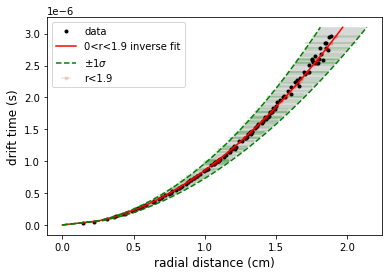

In [321]:
region=CTL880
cutoff=1.9
# need to choose a tfine that corresponds to r = cutoff (here r=1.9cm, t=3.1us)
tfine=np.linspace(0,3.1e-6)
popt1,perr1,popt2,perr2,popt3,perr3 = fit_err_low(region,cutoff)
err1,val1 = error_propagation(np.array(region.t)[region.r < cutoff],np.array(region.errt)[region.r < cutoff],popt2[0],perr2[0],popt2[1],perr2[1])

plt.errorbar(val1,np.array(region.t)[region.r < cutoff],xerr=err1,fmt='.',ecolor = 'green',alpha=0.13,color='red',label=f"r<{cutoff}")
plt.plot(region.r[region.r<cutoff],region.t[region.r<cutoff],'k.',label='data')
plt.plot(invertfunc(tfine,popt2[0],popt2[1]),tfine,'r-',label=f"0<r<{cutoff} inverse fit")
plt.plot(invertfunc(tfine,popt1[0],popt1[1]),tfine,color='green',linestyle='--',label=r'$\pm 1\sigma$')
plt.plot(invertfunc(tfine,popt3[0],popt3[1]),tfine,color='green',linestyle='--')

y1 = invertfunc(tfine,popt1[0],popt1[1])
y2 = invertfunc(tfine,popt3[0],popt3[1])

plt.fill_betweenx(tfine, y1, y2, facecolor="gray", alpha=0.3)
plt.legend()
plt.xlabel('radial distance (cm)',fontsize=12)
plt.ylabel('drift time (s)',fontsize=12)
plt.show()

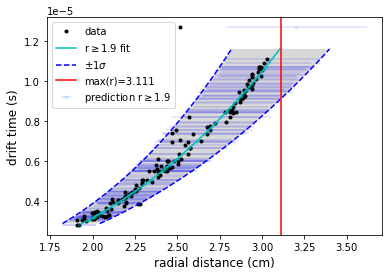

In [322]:
region=CTL880
cutoff = cutoff
popt,perr,popt2,perr2 = perform_fit(region,cutoff)
err2,val2 = error_propagation(np.array(region.t)[region.r >= cutoff],np.array(region.errt)[region.r >= cutoff],popt2[0],perr2[0],popt2[1],perr2[1])
plt.plot(region.r[region.r >= cutoff],np.array(region.t)[region.r >= cutoff],'k.',label='data')
plt.errorbar(val2,np.array(region.t)[region.r >= cutoff],xerr=err2,fmt='.',ecolor = 'b',alpha=0.13,color='c',label=r'prediction r$\geq$1.9')
plt.legend(loc='upper left')
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(2.9e-6,11.6e-6)
plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'c-',label=f'r$\geq${cutoff} fit')
popt1,pcov1 = curve_fit(trialfunc,val2+err2,np.array(region.t)[region.r >= cutoff],p0=[a_guess,b_guess])
popt4,pcov4 = curve_fit(trialfunc,val2-err2,np.array(region.t)[region.r >= cutoff],p0=[a_guess,b_guess])
plt.plot(invertfunc(tfine2,popt1[0],popt1[1]),tfine2,'b--',label=r'$\pm 1\sigma$')
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),tfine2,'b--')
y1 = invertfunc(tfine2,popt1[0],popt1[1])
y2 = invertfunc(tfine2,popt4[0],popt4[1])
plt.fill_betweenx(tfine2, y1, y2, facecolor="gray", alpha=0.3)
plt.axvline(x=np.sqrt(2.2**2+2.2**2),color='red',label=f'max(r)={max_cell_len:.3f}')
plt.legend()
plt.xlabel('radial distance (cm)',fontsize=12)
plt.ylabel('drift time (s)',fontsize=12)
plt.show()

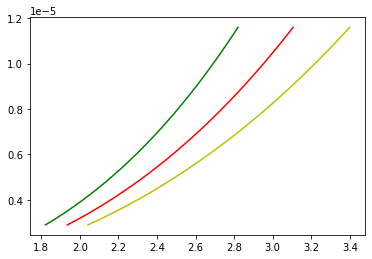

In [323]:
plt.plot(invertfunc(tfine2,popt1[0],popt1[1]),tfine2,'y-',label='+/- 1sigma')
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),tfine2,'g-')
plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'r-',label='r>2.2 fit')

In [324]:
def inversefit_plot(region,label):
    popt,perr,popt2,perr2 = perform_fit(region,2.2)
    err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
    err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])
    plt.errorbar(region.r,np.array(region.t),yerr=np.array(region.errt),fmt='.',ecolor = 'pink',color='red',label='data')
    plt.errorbar(val1,np.array(region.t)[region.r < 2.2],xerr=err1,fmt='.',ecolor = 'cyan',color='black',label='prediction r<2.2')
    plt.errorbar(val2,np.array(region.t)[region.r >= 2.2],xerr=err2,fmt='.',ecolor = 'green',alpha=0.2,color='black',label='prediction r>2.2')
    plt.legend(loc='upper left')
    plt.title('Inverse fit with error bars'+' '+str(label))
    plt.ylabel(r'drift time (s)')
    plt.xlabel('radial distance (cm)')
    plt.show()

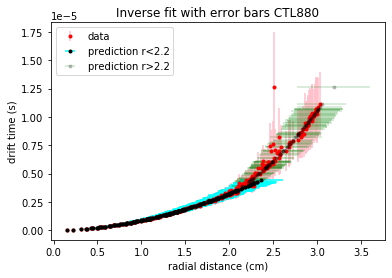

In [325]:
inversefit_plot(CTL880,'CTL880')

In [326]:
# getting best fit parameters from minuit and proving independence
from probfit import Chi2Regression
import iminuit
import probfit


In [327]:
x2reg= Chi2Regression(trialfunc, region.r[region.r<2.2], region.t[region.r<2.2], error=region.errt[region.r<2.2])
region = CTL880

In [328]:
def best_fit(cutoff):
    chi2 = probfit.Chi2Regression(trialfunc, region.r[region.r<cutoff], region.t[region.r<cutoff], region.errt[region.r<cutoff])
    minuit = iminuit.Minuit(chi2, a=a_guess, b=b_guess) # see iminuit tutorial on how to give initial value/range/error
    minuit.migrad()
    vals = minuit.values
    errs = minuit.errors
    chi2_hi = probfit.Chi2Regression(trialfunc, region.r[region.r>=cutoff], region.t[region.r>=cutoff], region.errt[region.r>=cutoff])
    minuit_hi = iminuit.Minuit(chi2_hi, a=a_guess, b=b_guess2) # see iminuit tutorial on how to give initial value/range/error
    minuit_hi.migrad()
    vals_hi = minuit_hi.values
    errs_hi = minuit_hi.errors
    return vals,errs,vals_hi,errs_hi

In [329]:
best_fit(1.9)

/tmp/ipykernel_303/3693129119.py:1: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  best_fit(1.9)


(<ValueView of Minuit at bf9b860>
   a: 8.533068690606196e-07
   b: -0.9011081879386615,
 <ErrorView of Minuit at bf9b860>
   a: 1.0420577963802205e-08
   b: 0.025545703766983036,
 <ValueView of Minuit at c18fba0>
   a: 4.192666126773892e-07
   b: -1.9295987055019816,
 <ErrorView of Minuit at c18fba0>
   a: 4.347150530599264e-08
   b: 0.12155101796425133)

In [330]:
trialfunc(1.9,8.533068690606196e-07,-0.9011081879386615)

2.890986042144752e-06

In [331]:
chi2 = probfit.Chi2Regression(trialfunc, region.r[region.r<1.9], region.t[region.r<1.9], region.errt[region.r<1.9])
minuit = iminuit.Minuit(chi2, a=1e-6, b=-2) # see iminuit tutorial on how to give initial value/range/error
minuit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.727                      │         Nfcn = 57 (57 total)         │
│ EDM = 4.92e-08 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 0.853e-6  │ 0.010e-6  │            │            │         │         │       │
│ 1 │ b    │  -0.901   │   0.026   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [332]:
print(minuit.values)
print(minuit.errors)


<ValueView of Minuit at 7704b20>
  a: 8.532977991469658e-07
  b: -0.9011476018896774
<ErrorView of Minuit at 7704b20>
  a: 1.0420622803199454e-08
  b: 0.02554699854231376


In [333]:
print(minuit.matrix(correlation=True))


┌───┬─────────────┐
│   │     a     b │
├───┼─────────────┤
│ a │ 1.000 0.105 │
│ b │ 0.105 1.000 │
└───┴─────────────┘


((array([1.06696234, 1.17845492, 1.36290896, 1.47773794, 1.37239549,
         0.64693043, 0.36436417, 0.58930868, 1.0080327 , 0.82251093,
         1.2099565 , 1.77471982, 0.88095241, 1.5301425 , 1.10877032,
         0.90695642, 0.48951656, 1.46298481, 0.79593712, 1.41374457,
         1.75439871, 0.86707639, 1.20945416, 1.30782153, 1.2816018 ,
         0.92846948, 1.32833954, 1.02569539, 0.53401982, 1.40765094,
         0.90017804, 1.60553801, 1.47564791, 0.69341865, 0.4480546 ,
         1.08327435, 1.69777745, 1.32362664, 0.58079149, 0.92409737,
         0.5121113 , 1.09680692, 1.427746  , 0.31205211, 0.3762826 ,
         1.13665374, 1.18586559, 0.4403473 , 1.35236682, 1.58336178,
         1.36942691, 1.46577166, 0.99240296, 1.64959474, 0.94726718,
         1.10398439, 1.33626362, 1.49875451, 1.40148339, 1.04269572,
         1.44587746, 0.63459968, 0.2217289 , 1.09821206, 0.55952421,
         1.15198467, 0.7011051 , 1.19175227, 1.16900937, 1.01543345,
         0.94553251, 1.473035  , 1

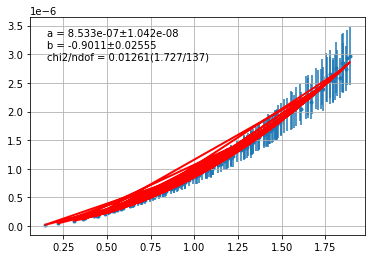

In [334]:
chi2.draw(minuit)

In [335]:
chi2 = probfit.Chi2Regression(trialfunc, region.r[region.r>=1.9], region.t[region.r>=1.9], region.errt[region.r>=1.9])
minuit = iminuit.Minuit(chi2, a=1e-6, b=b_guess2) # see iminuit tutorial on how to give initial value/range/error
minuit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.48                      │         Nfcn = 64 (64 total)         │
│ EDM = 3.77e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  0.42e-6  │  0.04e-6  │            │            │         │         │       │
│ 1 │ b    │   -1.93   │   0.12    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [336]:
minuit.values

<ValueView of Minuit at 7ad86f0>
  a: 4.192666126773892e-07
  b: -1.9295987055019816

In [337]:
print(minuit.matrix(correlation=True))

┌───┬─────────────┐
│   │     a     b │
├───┼─────────────┤
│ a │ 1.000 0.987 │
│ b │ 0.987 1.000 │
└───┴─────────────┘


massively correlated (?)

((array([1.9471473 , 2.11564533, 2.27310183, 2.21415474, 2.25225364,
         2.38799036, 1.90788367, 2.50299739, 2.51894945, 2.44258673,
         2.18841608, 2.54538001, 2.25732716, 2.56135611, 2.67649096,
         2.21597532, 2.19169738, 2.41203494, 2.4536834 , 2.44392423,
         2.44123052, 2.44014565, 2.69122731, 2.28997675, 2.43819366,
         2.38376679, 2.57726357, 2.43520747, 2.42856605, 2.64223971,
         2.39039958, 2.28874322, 2.22987146, 2.2966398 , 2.14975894,
         2.44744266, 2.25555046, 2.16979079, 2.46626893, 2.22391281,
         2.02076868, 2.8952359 , 2.89646077, 2.93947231, 2.8294047 ,
         2.9645681 , 2.94166868, 3.01461159, 2.98450605, 2.90001791,
         2.99582487, 2.89727968, 2.78538433, 2.87839484, 2.93974695,
         2.86891044, 2.89715878, 2.91778709, 2.82027124, 2.8118274 ,
         2.90869236, 2.83891399, 2.94688992, 2.99438947, 2.93226889,
         2.9846035 , 2.86291098, 2.98518844, 2.93878403, 2.9428154 ,
         2.84561245, 2.9210505 , 2

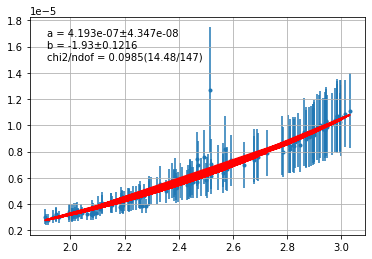

In [338]:
chi2.draw(minuit)

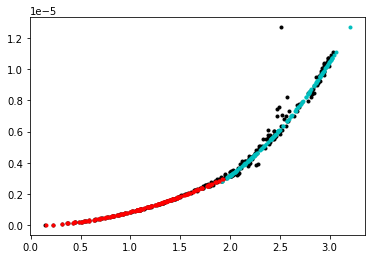

In [339]:
plt.plot(region.r,region.t,'k.')
plt.plot(invertfunc(region.t[region.r>=1.9],4.192666126773892e-07,-1.9295987055019816),region.t[region.r>=1.9],'c.')
plt.plot(invertfunc(region.t[region.r<1.9],8.532977991469658e-07,-0.9011476018896774),region.t[region.r<1.9],'r.')



---

Pull plot:
$$\frac{\hat{\chi} - \chi}{\sigma}$$

In [340]:
def pull_plot(region,cutoff):
    popt,perr,popt2,perr2 = perform_fit(region,cutoff)
    err1,val1 = error_propagation(np.array(region.t)[region.r < cutoff],np.array(region.errt)[region.r < cutoff],popt[0],perr[0],popt[1],perr[1])
    err2,val2 = error_propagation(np.array(region.t)[region.r >= cutoff],np.array(region.errt)[region.r >= cutoff],popt2[0],perr2[0],popt2[1],perr2[1])
    pull1 = (val1-region.r[region.r < cutoff])/err1
    pull2 = (val2-region.r[region.r >= cutoff])/err2
    fig, ax = plt.subplots(figsize =(6, 5))
    ax.plot(region.r[region.r < cutoff],pull1,'c.')
    ax.set_ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
    ax.set_xlabel('radial distance (cm)')
    plt.title(f'Pull plot for r<{cutoff}')
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax.hlines(y=0,xmin=0,xmax=cutoff,linestyles='dashed')
    ax.set_ylim([-1,1])
    plt.legend()
         

No handles with labels found to put in legend.


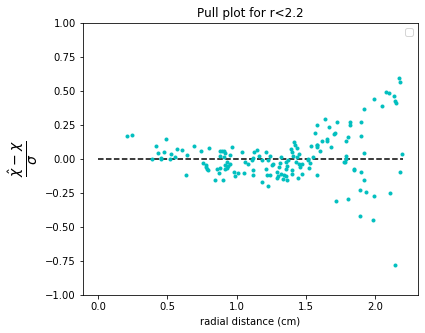

In [341]:
pull_plot(CTL850,2.2)

Paramater map for each region for different pressures:

In [342]:
regions = [CTL850, CTL880, CTL910, TLL850, TLL880, TLL910, TLR850, TLR880, TLR910]
cutoff = 2.2
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions)):
    popt,perr,popt2,perr2 = perform_fit(regions[i],cutoff)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])


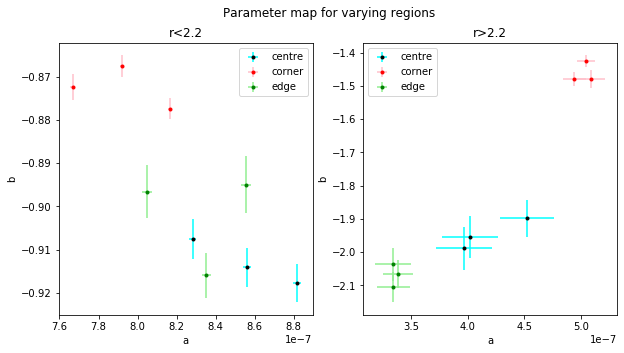

In [343]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying regions')


ax1.errorbar(a[0:3],b[0:3],xerr=erra[0:3],yerr=errb[0:3],fmt='.',ecolor = 'cyan',color='black',label='centre')
ax1.errorbar(a[3:6],b[3:6],xerr=erra[3:6],yerr=errb[3:6],fmt='.',ecolor = 'pink',color='red',label='corner')
ax1.errorbar(a[6:9],b[6:9],xerr=erra[6:9],yerr=errb[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='edge')

ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title(f'r<{cutoff}')
ax1.legend()

ax2.errorbar(a2[0:3],b2[0:3],xerr=erra2[0:3],yerr=errb2[0:3],fmt='.',ecolor = 'cyan',color='black',label='centre')
ax2.errorbar(a2[3:6],b2[3:6],xerr=erra2[3:6],yerr=errb2[3:6],fmt='.',ecolor = 'pink',color='red',label='corner')
ax2.errorbar(a2[6:9],b2[6:9],xerr=erra2[6:9],yerr=errb2[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='edge')

ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title(f'r>{cutoff}')
ax2.legend()
plt.show()

In [344]:
regions2 = [CTL850, TLL850, TLR850, CTL880, TLL880, TLR880, CTL910, TLL910, TLR910]
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions2)):
    popt,perr,popt2,perr2 = perform_fit(regions2[i],cutoff)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])

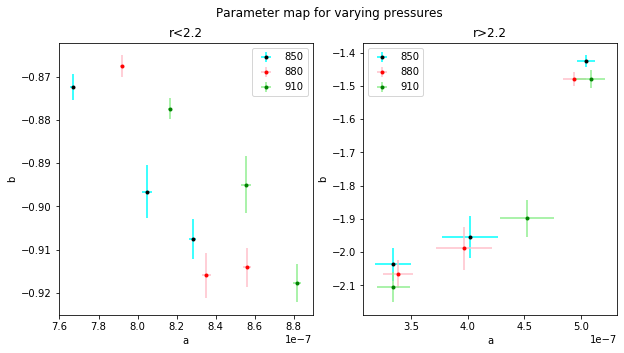

In [345]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying pressures')


ax1.errorbar(a[0:3],b[0:3],xerr=erra[0:3],yerr=errb[0:3],fmt='.',ecolor = 'cyan',color='black',label='850')
ax1.errorbar(a[3:6],b[3:6],xerr=erra[3:6],yerr=errb[3:6],fmt='.',ecolor = 'pink',color='red',label='880')
ax1.errorbar(a[6:9],b[6:9],xerr=erra[6:9],yerr=errb[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='910')

ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title(f'r<{cutoff}')
ax1.legend()

ax2.errorbar(a2[0:3],b2[0:3],xerr=erra2[0:3],yerr=errb2[0:3],fmt='.',ecolor = 'cyan',color='black',label='850')
ax2.errorbar(a2[3:6],b2[3:6],xerr=erra2[3:6],yerr=errb2[3:6],fmt='.',ecolor = 'pink',color='red',label='880')
ax2.errorbar(a2[6:9],b2[6:9],xerr=erra2[6:9],yerr=errb2[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='910')

ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title(f'r>{cutoff}')
ax2.legend()
plt.show()

In [346]:
h = np.array(a)/1e-7

In [347]:
b7 = np.array(b).reshape(3,3)

In [348]:
Blues = plt.get_cmap('Blues')

In [349]:
h3 = h.reshape(3,3)

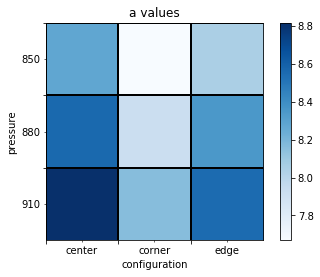

In [350]:
fig, ax = plt.subplots()
u = ax.imshow(h3, cmap=Blues)#, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, 2.5, 1));
ax.set_yticks(np.arange(-.5, 2.5, 1));
ax.set_title('a values')
ax.set_xticklabels(['center','corner','edge'])
ax.set_yticklabels(['850','880','910'])
ax.set_xlabel('configuration')
ax.set_ylabel('pressure')

# Hide major tick labels
ax.set_xticklabels('')
ax.set_yticklabels('')

# Customize minor tick labels
ax.set_xticks([0,1,2],      minor=True)
ax.set_yticks([0,1,2],      minor=True)

ax.set_xticklabels(['center','corner','edge'],minor=True)
ax.set_yticklabels(['850','880','910'],minor=True)

fig.colorbar(u)
#ax.set_yticks([])
#ax.set_xticks([])

plt.show()

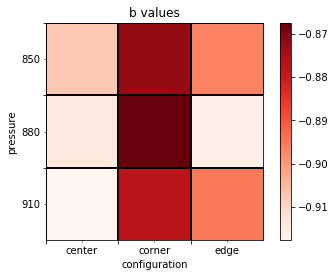

In [351]:
fig, ax = plt.subplots()
Summer = plt.get_cmap('Reds')
u = ax.imshow(b7, cmap=Summer)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, 2.5, 1));
ax.set_yticks(np.arange(-.5, 2.5, 1));
ax.set_title('b values')
ax.set_xlabel('configuration')
ax.set_ylabel('pressure')

# Hide major tick labels
ax.set_xticklabels('')
ax.set_yticklabels('')

# Customize minor tick labels
ax.set_xticks([0,1,2],      minor=True)
ax.set_yticks([0,1,2],      minor=True)

ax.set_xticklabels(['center','corner','edge'],minor=True)
ax.set_yticklabels(['850','880','910'],minor=True)

fig.colorbar(u)
plt.show()

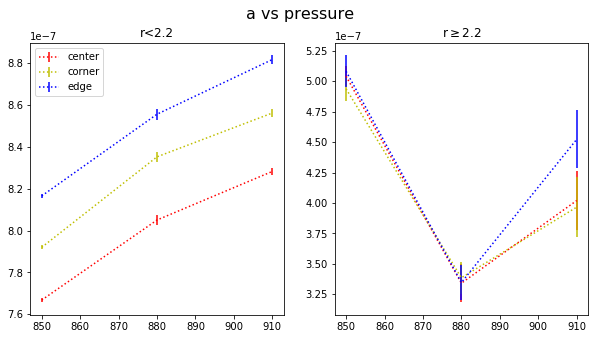

In [352]:
ls = 'dotted'
regions2 = [TLL850, TLR850, CTL850, TLL880, TLR880, CTL880, TLL910, TLR910, CTL910]
#corner, edge, centre
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions2)):
    popt,perr,popt2,perr2 = perform_fit(regions2[i],2.2)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('a vs pressure',fontsize=16)
y = np.array([850,880,910])
ax1.errorbar(y,a[0:3],yerr=erra[0:3],fmt='r',
            linestyle=ls,label='center')
ax1.errorbar(y,a[3:6],yerr=erra[3:6],fmt='y',label='corner',
            linestyle=ls)
ax1.errorbar(y,a[6:9],yerr=erra[6:9],fmt='b',label='edge',
            linestyle=ls)
ax2.errorbar(y,a2[0:3],yerr=erra2[0:3],fmt='r',label='center',
            linestyle=ls)
ax2.errorbar(y,a2[3:6],yerr=erra2[3:6],fmt='y',label='corner',
            linestyle=ls)
ax2.errorbar(y,a2[6:9],yerr=erra2[6:9],fmt='b',label='edge',
            linestyle=ls)
ax1.set_title('r<2.2')
ax2.set_title(r'r$\geq2.2$')
ax1.legend()
plt.show()

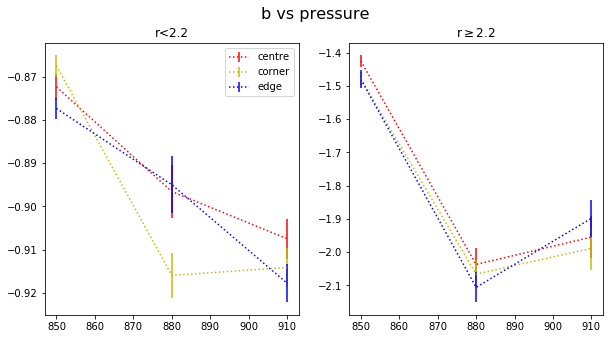

In [353]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('b vs pressure',fontsize=16)
y = np.array([850,880,910])
ax1.errorbar(y,b[0:3],yerr=errb[0:3],
            linestyle=ls,fmt='r',label='centre')
ax1.errorbar(y,b[3:6],yerr=errb[3:6],label='corner',
            linestyle=ls,fmt='y')
ax1.errorbar(y,b[6:9],yerr=errb[6:9],label='edge',
            linestyle=ls,fmt='b')
ax2.errorbar(y,b2[0:3],yerr=errb2[0:3],label='centre',
            linestyle=ls,fmt='r')
ax2.errorbar(y,b2[3:6],yerr=errb2[3:6],label='corner',
            linestyle=ls,fmt='y')
ax2.errorbar(y,b2[6:9],yerr=errb2[6:9],label='edge',
            linestyle=ls,fmt='b')
ax1.set_title('r<2.2')
ax2.set_title(r'r$\geq2.2$')
ax1.legend()
plt.show()

#### ANGULAR DEPENDENCE

Alternative drift models are
under investigation for SuperNEMO, some of which include the angle of incidence of
the track as a parameter.

In [354]:
import math
import scipy.interpolate

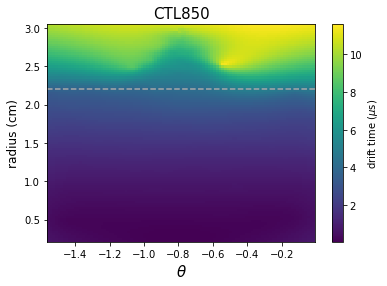

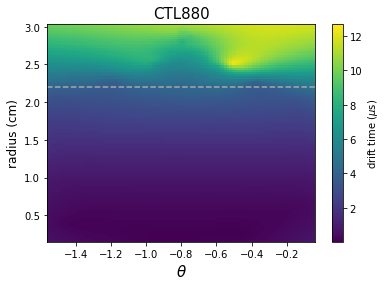

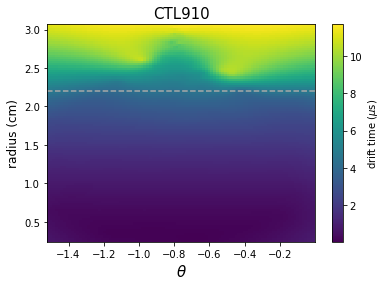

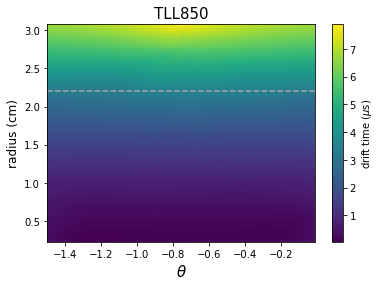

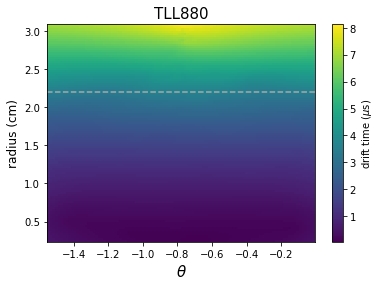

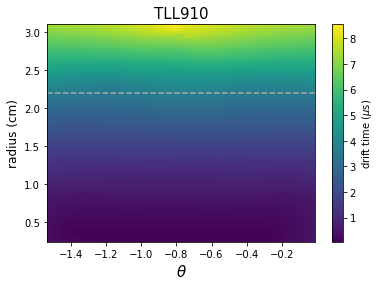

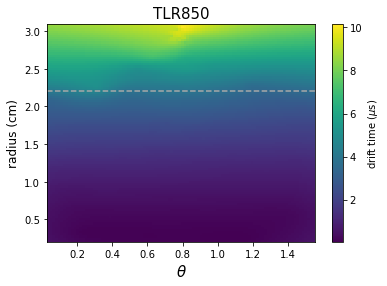

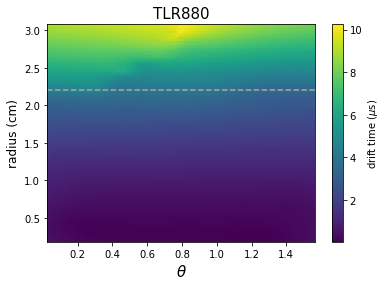

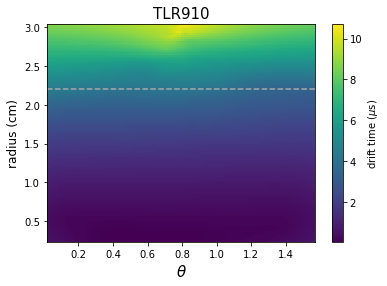

In [355]:
count = 0
for region in regions:
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)

    plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
               extent=[x.min(), x.max(), y.min(), y.max()],aspect='auto')
    plt.title(cell_names[count],fontsize=15)
    cbar = plt.colorbar()
    cbar.set_label(r'drift time ($\mu$s)')
    plt.xlabel(r'$\theta$',fontsize=15)
    plt.ylabel(r'radius (cm)',fontsize=12)
    plt.axhline(y = 2.2, color = 'darkgray', linestyle = '--')
    plt.show()
    
    count+=1


In [356]:
new_regions = [CTL850, TLL850, TLR850]

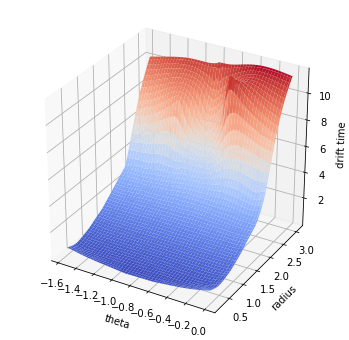

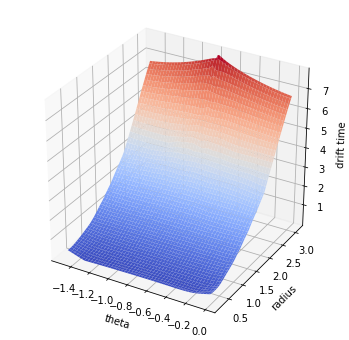

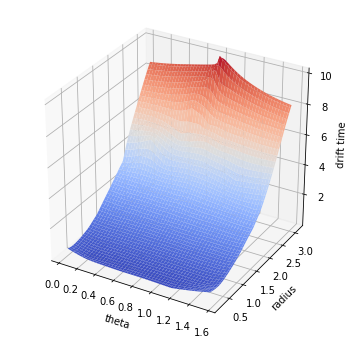

In [357]:
for region in new_regions:
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(xi, yi, zi, cmap='coolwarm')

    ax.set_xlabel('theta')
    ax.set_ylabel('radius')
    ax.set_zlabel('drift time')

    plt.show()

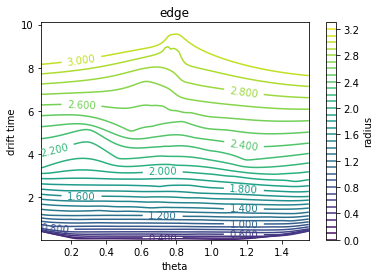

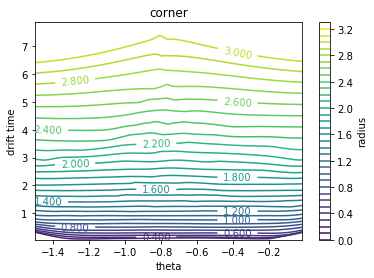

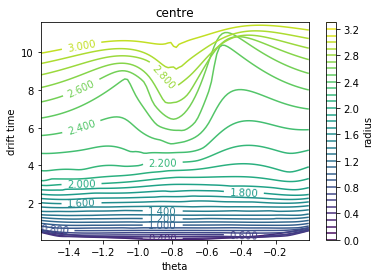

In [358]:
new_regions = [TLR850, TLL850, CTL850]
count=0
for region in new_regions:
    name=['edge','corner','centre']
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    levels=np.arange(0,3.4,0.1)
    cs = plt.contour(xi,zi,yi,levels=levels)
    plt.colorbar(cs,label='radius')
    plt.clabel(cs,cs.levels[::2])

    plt.xlabel('theta')
    plt.ylabel('drift time')
    plt.title(name[count])
    plt.show()
    count+=1

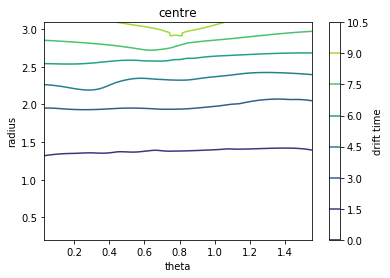

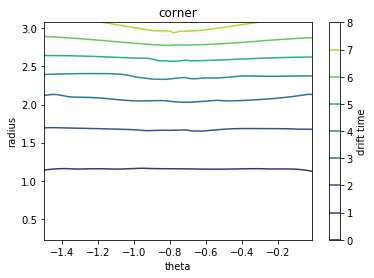

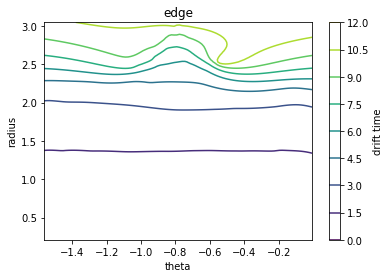

In [359]:
count=0
for region in new_regions:
    name=['centre','corner','edge']
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    cs = plt.contour(xi,yi,zi)
    plt.colorbar(cs,label='drift time')
    
    plt.xlabel('theta')
    plt.ylabel('radius')
    plt.title(name[count])
    plt.show()
    count+=1

A straight contour line (uniform) means no angular dependence and non uniform lines show angular dependence in cells - there is a clear theta dependence in edge and centre cells

(-1.5707963267948966, 0)

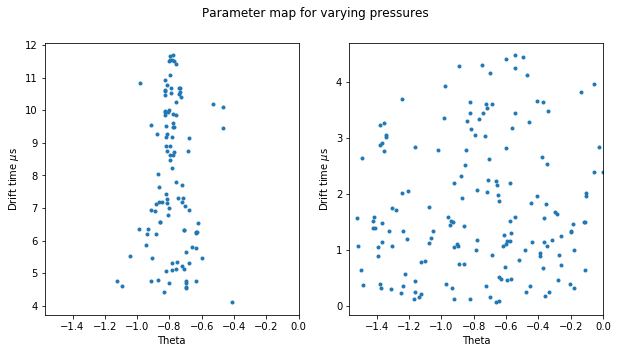

In [360]:
region = CTL910
w = np.array(region.y)/np.array(region.x)
theta = np.arctan(w)
y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
z = np.array(region.t)/1e-6
data = list(zip(theta,z,y))

dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  
df_r1 = dframe[dframe['radius'].between(2.2, 3.1, inclusive=False)]
df_r2 = dframe[dframe['radius'].between(0, 2.2, inclusive=False)]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying pressures')

ax1.plot(df_r1['theta'],df_r1['drift time'],'.')
ax2.plot(df_r2['theta'],df_r2['drift time'],'.')

ax1.set_xlabel('Theta')
ax2.set_xlabel('Theta')

ax1.set_ylabel(r'Drift time $\mu$s')
ax2.set_ylabel(r'Drift time $\mu$s')

ax1.set_xlim([-np.pi/2,0])
ax2.set_xlim([-np.pi/2,0])

The shape of this plot of drift time against angle is due to how it is sampled (imagine filling in a square with circular radius 2.2, not many sampling points in the highest and lowest theta values). Since the gaussian is filled, there still shows no real trend between theta and drift time.

-----------------------------------------------------------------------------------------------------------------------------

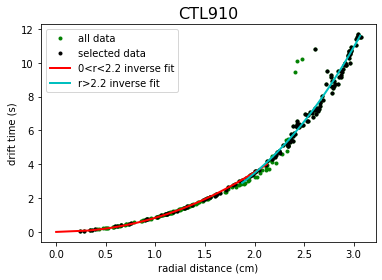

In [361]:
# the reason the fit is poor when joining the two regions at cutoff e.g. 2.2 is because of the new asmmetry of the cell 
# Here we highlight the data points at certain angles that don't fit the trend
region = CTL910
w = np.array(region.y)/np.array(region.x)
theta = np.arctan(w)
y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
z = np.array(region.t)/1e-6
data = list(zip(theta,z,y))
dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  
df_r1 = dframe[dframe['theta'].between(-1, -0.6, inclusive=False)]
dnew = dframe.drop(np.array(df_r1.index))
popt,pcov = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],p0=[a_guess,b_guess])
popt2,pcov2 = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],p0=[a_guess,b_guess])

plt.plot(dframe['radius'],dframe['drift time'],'g.',label='all data')
plt.plot(df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],'k.',label='selected data')
plt.plot(df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],'k.')
plt.plot(invertfunc(tfine/1e-6,popt[0],popt[1]),tfine/1e-6,'r-',linewidth=2,label='0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine2/1e-6,popt2[0],popt2[1]),tfine2/1e-6,'c-',linewidth=2,label='r>2.2 inverse fit')
plt.title('CTL910',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

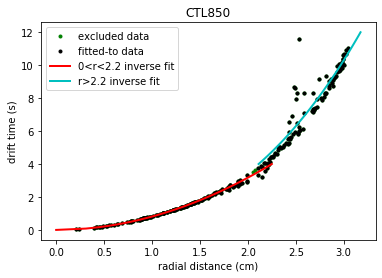

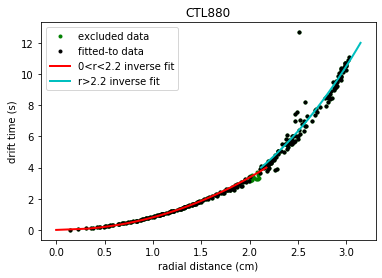

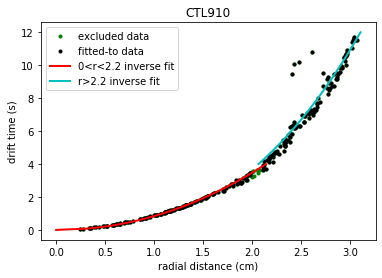

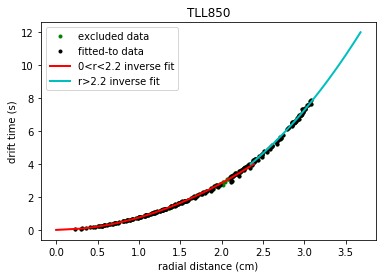

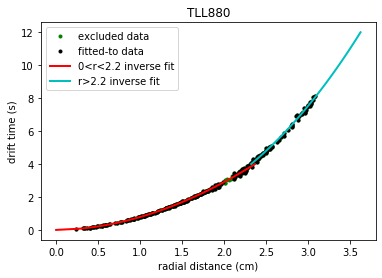

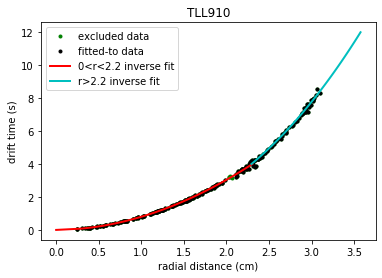

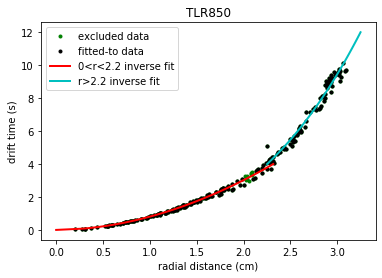

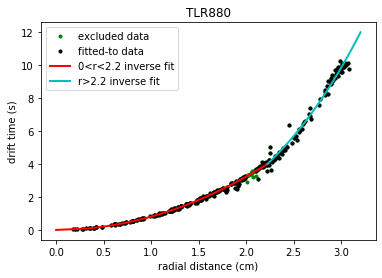

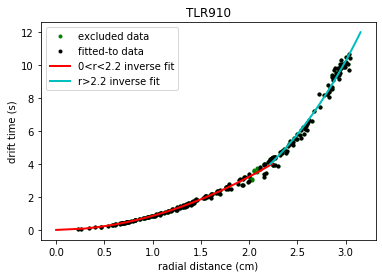

In [362]:
region = CTL850
count=0
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
for region in regions:
    w = np.array(region.y)/np.array(region.x)
    theta = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    data = list(zip(theta,z,y))
    dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  

    df_r1 = dframe[dframe['radius'].between(2, 2.1, inclusive=False)]
    dframe2 = dframe.drop(df_r1.index)
    popt,pcov = curve_fit(trialfunc,dframe2['radius'][dframe2['radius']<2.2],dframe2['drift time'][dframe2['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    popt2,pcov2 = curve_fit(trialfunc,dframe2['radius'][dframe2['radius']>=2.2],dframe2['drift time'][dframe2['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    
    plt.plot(dframe['radius'],dframe['drift time'],'g.',label='excluded data')
    plt.plot(dframe2['radius'][dframe2['radius']<2.2],dframe2['drift time'][dframe2['radius']<2.2],'k.',label='fitted-to data')
    plt.plot(dframe2['radius'][dframe2['radius']>=2.2],dframe2['drift time'][dframe2['radius']>=2.2],'k.')#,label='data')
    plt.plot(invertfunc(tfine/1e-6,popt[0],popt[1]),tfine/1e-6,'r-',linewidth=2,label='0<r<2.2 inverse fit')
    plt.plot(invertfunc(tfine2/1e-6,popt2[0],popt2[1]),tfine2/1e-6,'c-',linewidth=2,label='r>2.2 inverse fit')
    plt.legend()
    plt.title(cell_names[count])
    plt.xlabel('radial distance (cm)')
    plt.ylabel('drift time (s)')
    plt.show()
    count+=1


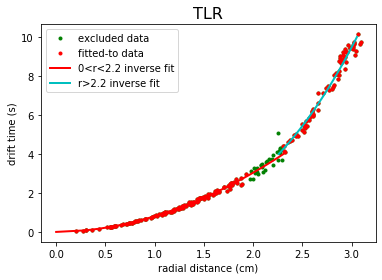

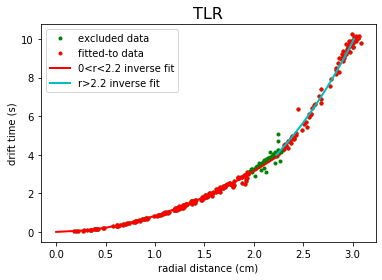

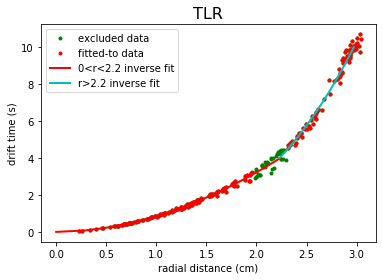

In [363]:
list2 = [TLR850, TLR880, TLR910]
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,10e-6)
for region in list2:
    w = np.array(region.y)/np.array(region.x)
    theta = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    data = list(zip(theta,z,y))

    dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  
    df_r1 = dframe[dframe['radius'].between(1.95, 2.3, inclusive=False)]
    dframe2 = dframe.drop(df_r1.index)
    a = np.linspace(1.95,2.3,100)
    df = dframe[~dframe['radius'].isin(a)]
    popt,pcov = curve_fit(trialfunc,dframe2['radius'][dframe2['radius']<2.2],dframe2['drift time'][dframe2['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    popt2,pcov2 = curve_fit(trialfunc,dframe2['radius'][dframe2['radius']>=2.2],dframe2['drift time'][dframe2['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    plt.plot(dframe['radius'],dframe['drift time'],'g.',label='excluded data')
    plt.plot(dframe2['radius'][dframe2['radius']<2.2],dframe2['drift time'][dframe2['radius']<2.2],'r.')#,label='data')
    plt.plot(dframe2['radius'][dframe2['radius']>=2.2],dframe2['drift time'][dframe2['radius']>=2.2],'r.',label='fitted-to data')
    plt.plot(invertfunc(tfine/1e-6,popt[0],popt[1]),tfine/1e-6,'r-',linewidth=2,label='0<r<2.2 inverse fit')
    plt.plot(invertfunc(tfine2/1e-6,popt2[0],popt2[1]),tfine2/1e-6,'c-',linewidth=2,label='r>2.2 inverse fit')
    plt.title('TLR',fontsize=16)
    plt.legend()
    plt.xlabel('radial distance (cm)')
    plt.ylabel('drift time (s)')
    plt.show()


In [364]:
dframe2 = dframe.drop(df_r1.index)

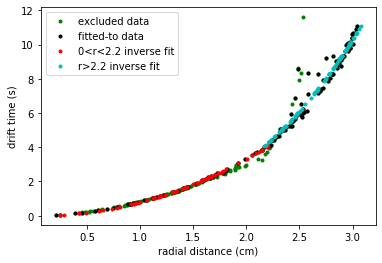

In [366]:
region = CTL850
w = np.array(region.y)/np.array(region.x)
theta = np.arctan(w)
y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
z = np.array(region.t)/1e-6
e = np.array(region.errt)/1e-6
data = list(zip(theta,z,y,e))

dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius', 'terr'])  
df_r1 = dframe[dframe['theta'].between(-1.1, -0.6, inclusive=False)]
popt,pcov = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)
popt2,pcov2 = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)

plt.plot(dframe['radius'],dframe['drift time'],'g.',label='excluded data')
plt.plot(df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],'k.',label='fitted-to data')
plt.plot(df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],'k.')
plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1]),df_r1['drift time'][df_r1['radius']<2.2],'r.',linewidth=2,label='0<r<2.2 inverse fit')
plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1]),df_r1['drift time'][df_r1['radius']>=2.2],'c.',linewidth=2,label='r>2.2 inverse fit')
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()